# 04-Evaluation hw

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('data/bank-full.csv', sep=';')
print(df.head())# View top 5 rows

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [28]:
print(df.columns)
print('-------------------------------------------')
df.dtypes

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')
-------------------------------------------


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
df.y

0         no
1         no
2         no
3         no
4         no
        ... 
45206    yes
45207    yes
45208    yes
45209     no
45210     no
Name: y, Length: 45211, dtype: object

In [6]:
#convert target value(y)
df.y = (df.y == 'yes').astype(int)
df.y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [7]:
#train test split
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

#del target from df
del df_train['y']
del df_val['y']
del df_test['y']

print(np.sum(y_train == 1))
print('------------------------------------------')
print(y_train[:10])
print('------------------------------------------')
print(df_train.columns)

3141
------------------------------------------
[0 0 0 1 0 0 0 0 1 0]
------------------------------------------
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')


In [8]:
#specifeic columns we wanted to use
selected_cols = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
]
df_selected = df[selected_cols]
numerical = df_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = df_selected.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical)
print("Categorical Columns:", categorical)

Numerical Columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical Columns: ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


## Q1: ROC AUC feature importance

In [9]:
from sklearn.metrics import roc_auc_score
auc_scores = {}
for col in numerical:
    y_score = df_train[col]
    y_true = y_train
    auc = roc_auc_score(y_true, y_score)
    if auc < 0.5:
        y_score = -y_score
        auc = roc_auc_score(y_true, y_score)
    auc_scores[col] = auc

for col, score in auc_scores.items():
    print(f"{col}: {score:.4f}")
print("max:",max(auc_scores, key=auc_scores.get))

age: 0.5122
balance: 0.5888
day: 0.5260
duration: 0.8147
campaign: 0.5715
pdays: 0.5901
previous: 0.5986
max: duration


## Q2: Training the model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
round(auc_score,3)

np.float64(0.901)

## Q3: Precision and Recall

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

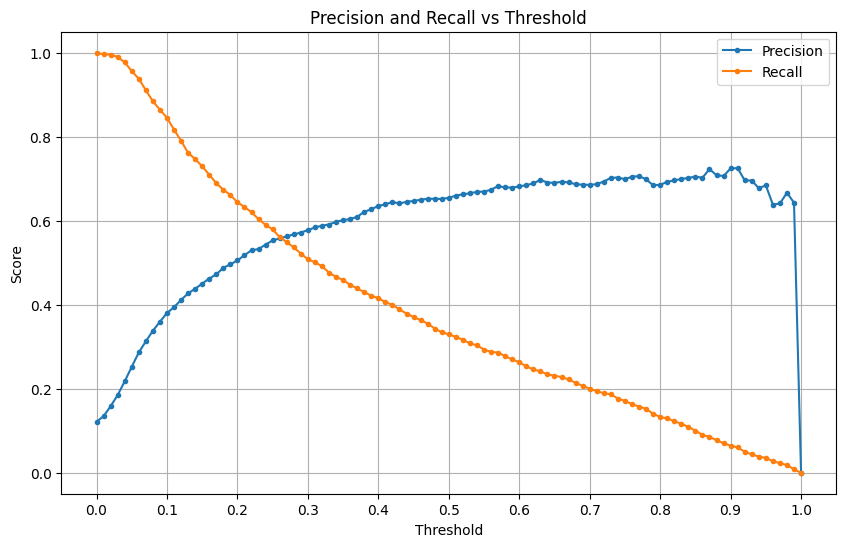

In [16]:
thresholds = np.arange(0.0, 1.01, 0.01)  

precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    
    precision = precision_score(y_val, y_pred_bin, zero_division=0)
    recall = recall_score(y_val, y_pred_bin, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plotting precision and recall vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o', markersize=3)
plt.plot(thresholds, recalls, label='Recall', marker='o', markersize=3)

# Set x-axis ticks with a gap of 0.1
plt.xticks(np.arange(0.0, 1.1, 0.1))

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
#it's around 2.65

## Q4: F1 score

In [18]:
thresholds = np.arange(0.0, 1.01, 0.01)  

F1 = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    
    p = precision_score(y_val, y_pred_bin, zero_division=0)
    r = recall_score(y_val, y_pred_bin, zero_division=0)
    
    f = (2 * p * r) / (p + r) if (p + r) > 0 else 0  # Avoid division by zero
    F1.append(f)
max_f1 = max(F1)
best_threshold = thresholds[np.argmax(F1)]

print(f'{max_f1:.3f} at {best_threshold:.2f}')

0.571 at 0.22


## Q5: 5-Fold CV

In [21]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# Iteratation
for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    df_train = df_train.drop(columns=['y'])
    df_val = df_val.drop(columns=['y'])

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    val_dict = df_val[categorical + numerical].to_dict(orient='records')

    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC for the current fold and store it
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

    print(f'AUC for this fold: {auc:.3f}')

std_dev_auc = np.std(auc_scores, ddof=1)
print(f'Standard Deviation of AUC: {std_dev_auc:.3f}')

AUC for this fold: 0.899
AUC for this fold: 0.899
AUC for this fold: 0.911
AUC for this fold: 0.908
AUC for this fold: 0.912
Standard Deviation of AUC: 0.006


In [23]:
def calculate_std(auc_scores):
    # Calculate the mean
    n = len(auc_scores)
    mean_auc = sum(auc_scores) / n
    # Calculate the squared differences from the mean
    squared_diffs = [(score - mean_auc) ** 2 for score in auc_scores]
    # Sum of squared differences
    sum_squared_diffs = sum(squared_diffs)
    # Calculate variance (using n - 1 for sample variance)
    variance = sum_squared_diffs / (n - 1)
    # Calculate standard deviation
    std_dev = variance ** 0.5
    
    return std_dev
std_result = calculate_std(auc_scores)
print(f'Standard Deviation of AUC scores: {std_result:.4f}')

Standard Deviation of AUC scores: 0.0064


## Q6: Hyperparameter Tuning

In [25]:
C_values = [0.000001, 0.001, 1]
results = {}
for C in C_values:
    auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # Iteratation
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        df_train = df_train.drop(columns=['y'])
        df_val = df_val.drop(columns=['y'])
    
        dv = DictVectorizer(sparse=False)
        train_dict = df_train[categorical + numerical].to_dict(orient='records')
        val_dict = df_val[categorical + numerical].to_dict(orient='records')
    
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
    
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:, 1]
    
        # Calculate AUC for the current fold and store it
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    n = len(auc_scores)
    mean_auc = sum(auc_scores) / n

    sum_squared_diffs = sum((score - mean_auc) ** 2 for score in auc_scores)
    variance = sum_squared_diffs / (n - 1)
    std_dev = variance ** 0.5
    results[C] = (round(mean_auc, 3), round(std_dev, 3))
    
for C, (mean_auc, std_dev) in results.items():
    print(f'C: {C}, Mean AUC: {mean_auc}, Std Dev: {std_dev}')
#BEST MEAN: 1

C: 1e-06, Mean AUC: 0.701, Std Dev: 0.011
C: 0.001, Mean AUC: 0.861, Std Dev: 0.008
C: 1, Mean AUC: 0.906, Std Dev: 0.006
